# Аспектный сентимент-анализ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
from livelossplot.outputs import MatplotlibPlot
from livelossplot import PlotLosses
from dlnlputils.sentiment_utils import plot_confusion_matrix
from dlnlputils.sentiment_utils import show_markup, prepare_data, generate_markup, parse_xml_aspect_sentiment, format_markup
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import gensim
# import wget
from dlnlputils.sentiment_utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from prettytable import PrettyTable
from sklearn.model_selection import KFold
import onnx
import onnxruntime as ort
import csv

torch.manual_seed(1)

In [2]:
word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [3]:
# xml_train = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
# xml_test  = 'datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'
xml_dataset = 'datasets/sentirueval2015/SentiRuEval_car_markup.xml'

In [4]:
texts_w_aspect_spans  = parse_xml_aspect_sentiment(xml_dataset)
texts_w_aspect_spans  = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
dataset, test_hold_dataset = train_test_split(prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize), test_size=0.1529) # 0.0319
dataset               = np.array(dataset, dtype=object)
test_hold_dataset     = np.array(test_hold_dataset, dtype=object)
print(len(dataset))
print(len(test_hold_dataset))

3500
632


## Статистика по тэгам

In [5]:
from collections import Counter
from collections import defaultdict

def form_vocabulary_and_classes(words_with_classes):
    dictionary = defaultdict(Counter)
    for words,classes in words_with_classes:
        for word, class_label in zip(words, classes):
            dictionary[class_label].update([word])
    return dictionary, set(dictionary.keys()) 

In [6]:
class2word_dictionary, classes = form_vocabulary_and_classes(dataset)

In [7]:
# word_counter['B-Comfort-positive'].most_common()#[-1]

In [8]:
class ClassesIndexer():
    def __init__(self, classes):
        self.index_to_class  = sorted(classes)
        self.class_to_index  = {class_label:index for index,class_label in enumerate(self.index_to_class)}
        
    def classes_to_index(self, classes):
        return torch.tensor([self.class_to_index[class_label] for class_label in classes], dtype=torch.long)
    
    def indices_to_classes(self, indices):
        return [self.index_to_class[index] for index in indices]

classes_indexer = ClassesIndexer(classes)
print(classes_indexer.class_to_index)

{'B-Comfort-negative': 0, 'B-Comfort-positive': 1, 'B-Comfort-unknown': 2, 'B-Driveability-negative': 3, 'B-Driveability-positive': 4, 'B-Driveability-unknown': 5, 'B-Reliability-negative': 6, 'B-Reliability-positive': 7, 'B-Reliability-unknown': 8, 'B-Whole-negative': 9, 'B-Whole-positive': 10, 'B-Whole-unknown': 11, 'I-Comfort-negative': 12, 'I-Comfort-positive': 13, 'I-Comfort-unknown': 14, 'I-Driveability-negative': 15, 'I-Driveability-positive': 16, 'I-Driveability-unknown': 17, 'I-Reliability-negative': 18, 'I-Reliability-positive': 19, 'I-Reliability-unknown': 20, 'I-Whole-negative': 21, 'I-Whole-positive': 22, 'I-Whole-unknown': 23, 'Other-unknown': 24}


In [9]:
class WordsIndexer():
    def words_to_index(self, words):
        indices = []
        for word in words:
            for character in word:
                indices.append(ord(character))
            indices.append(ord('\0'))
        return torch.tensor(indices, dtype=torch.long)

    def indices_to_words(self, indices):
        words = []
        word = ""
        for index in indices:
            if index == 0:
                words.append(word)
                word = ""
            else:
                word += chr(index)
        return words

words_indexer = WordsIndexer()

# example_words = ['Крутое', 'авто!']
# for example_words,_ in dataset[10:20]:
# example_words = ['все', 'плюсы', 'я', 'так', 'и', 'не', 'вспомню', 'но', 'основные', 'назвал', 'теперь', 'минусы', 'их', 'не', 'много', ',', 'но', 'все', 'таки', 'они', 'отпугивают', 'людей1', ')', 'это', 'то', 'что', 'запчасти', 'на', 'опель', 'тяжело', 'найти', 'хоть', 'машина', 'и', 'не', 'ломается', 'практически', 'при', 'должном', 'уходе', 'порой', 'что', 'бы', 'найти', 'необходимую', 'запчасть', 'нужно', 'постараться', '2', ')', 'ну', 'и', 'вторая', 'проблема', 'это', 'коррозия', 'до', '1995', 'года', 'автомобили', 'не', 'покрывались', 'антикоррозийным', 'покрытием', 'поэтому', 'если', 'запустить', 'состояние', 'машины', 'то', 'крылья', 'начнут', 'ржаветь', 'поможет', 'здесь', 'либо', 'краска', 'и', 'наждачная', 'бумага', 'либо', 'в', 'сети', 'очень', 'много', 'вариантов', 'как', 'все', 'это', 'наладить', 'в', 'худшем', 'случае', 'как', 'на', 'этом', 'опеле', 'ну', 'и', '3', 'небольшой', 'минус', 'это', 'то', 'что', 'на', 'старых', 'моделях', 'стоит', 'кассетная', 'автомагнитола', 'в', 'общем', 'машина', 'хорошая', 'если', 'будет', 'возможность', 'брать', 'ее', 'в', 'хорошем', 'состоянии', 'берите', '!', 'общее', 'впечатление', ':', 'удобно', ',', 'приятно', 'водить', ',', 'качественная']
# example_words_indices = words_indexer.words_to_index(example_words)
# example_words_decoded = words_indexer.indices_to_words(example_words_indices)
# print(f'example: words={example_words}; words_indices={example_words_indices}; words_decoded={example_words_decoded}')
# print(f'shape of example_words_indices: {example_words_indices.shape}')
# print(f'decode: {example_words == example_words_decoded}')

## fastText

In [10]:
# model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
# wget.download(model_url)

In [11]:
word2vector_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

In [12]:
# words = ['тачка', 'двигатель']
#
# for word in words:
#     print(word)
#
#     for i in w2v_model.most_similar(positive=[word], topn=10):
#         nearest_word      = i[0]
#         cosine_similarity = i[1]
#         print(nearest_word, cosine_similarity)
#     print('\n')

# Конвертер слов в векторы fasttext:

In [13]:
class WordEmbedder:
    def __init__(self, word2vector_model):
        self.word2vector_model = word2vector_model

    def convert(self, words):
        embeddings = [self.word2vector_model.get_vector(word) for word in words]
        embeddings = torch.FloatTensor(embeddings)
        return embeddings

In [14]:
word_embedder = WordEmbedder(word2vector_model)

words,_ = dataset[333]
vectors = word_embedder.convert(words)

vectors.shape

/var/folders/3l/7hvfj3895f729zj8r810ttj00000gn/T/ipykernel_40651/1187378646.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  embeddings = torch.FloatTensor(embeddings)


torch.Size([20, 300])

##  AspectBasedClassifier

In [15]:
class AspectBasedClassifier(nn.Module):
    def __init__(
            self,
            embedding_dim, hidden_dim, output_dim,
            embedding_layer, hidden_layer,
            num_epochs, loss_function,
            classes_indexer,
            words_indexer,
            loss_epoch_graphic=None,
            loss_graphic=None,
            metrics=None, metrics_table=None
    ):
        super(AspectBasedClassifier, self).__init__()

        self.embedding_layer    = embedding_layer
        self.hidden_layer       = hidden_layer
        self.linear_layer       = nn.Linear(2*hidden_dim, output_dim)
        self.num_epochs         = num_epochs
        self.loss_function      = loss_function
        self.optimizer          = optim.SGD(self.parameters(), lr=0.1)
        self.classes_indexer    = classes_indexer
        self.words_indexer      = words_indexer
        self.loss_epoch_graphic = None
        self.loss_graphic       = None
        self.metrics            = None
        self.metrics_table      = None

    def forward(self, input_words_indices):
        input_words                 = self.words_indexer.indices_to_words(input_words_indices)
        words_embeddings            = self.embedding_layer.convert(input_words)
        context_sensitive_result, _ = self.hidden_layer(words_embeddings.view(len(input_words), 1, -1))
        linear_layer_output         = self.linear_layer(context_sensitive_result.view(len(input_words), -1))
        classes_scores              = F.log_softmax(linear_layer_output, dim=1)
        return classes_scores

    def fit(self, training_data, iteration=None):
        liveplot = PlotLosses()
        losses = []

        for epoch in range(self.num_epochs):
            epoch_losses = []

            for i, (words, classes) in enumerate(training_data):
                self.zero_grad()

                class_real      = self.classes_indexer.classes_to_index(classes)
                class_predicted = self(self.words_indexer.words_to_index(words))

                loss = self.loss_function(class_predicted, class_real)
                loss.backward()
                epoch_losses.append(loss.item())
                self.optimizer.step()

                if i % 100 == 0:
                    liveplot.update({'negative log likelihood loss (training data)': loss})
                    liveplot.draw()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        plt.plot(np.linspace(1, self.num_epochs, self.num_epochs).astype(int), losses)
        plt.savefig(fname=f'loss-{self.num_epochs}-{iteration}.png')

    def predict(self, words):
        with torch.no_grad():
            scores = self(self.words_indexer.words_to_index(words))
            classes_predicted = np.argmax(scores.numpy(), axis=1)
        return classes_predicted

    def get_metrics(self, ordered_classes, data, iteration=None):
        y_pred = []
        y_true = []

        for words, classes in data:
            y_pred += self.classes_indexer.indices_to_classes(self.predict(words))
            y_true += classes

        cm = confusion_matrix(y_true, y_pred, labels=ordered_classes)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # <- нормализация

        plot_confusion_matrix(cm, classes=ordered_classes, normalize=True, title='Нормализованная матрица ошибок')
        plt.savefig(f'model-{self.num_epochs}-{iteration}.png')
        plt.show()

        metrics_table = ['Metric', 'Value']
        f1s = []
        acc = accuracy_score(y_true, y_pred)
        metrics_table.append(['Accuracy', f'{acc:.2f}'])
        for class_label in ordered_classes:
            precision = precision_score(y_true, y_pred, average=None, labels=[class_label], zero_division=0)[0]
            recall = recall_score(y_true, y_pred, average=None, labels=[class_label])[0]
            f1 = f1_score(y_true, y_pred, average=None, labels=[class_label])[0]
            metrics_table.append([f'Precision_{class_label}', f'{precision:.2f}'])
            metrics_table.append([f'Recall_{class_label}', f'{recall:.2f}'])
            metrics_table.append([f'F1_{class_label}', f'{f1:.2f}'])
            f1s.append(f1)

        f1_micro = f1_score(y_true, y_pred, average="micro", labels=ordered_classes)
        f1_macro = f1_score(y_true, y_pred, average="macro", labels=ordered_classes)
        metrics_table.append(['F1-micro', f'{f1_micro:.2f}'])
        metrics_table.append(['F1-macro', f'{f1_macro:.2f}'])

        self.metrics = {
            'confusion_matrix': cm, 'accuracy': acc, 'f1_micro': f1_micro, 'f1_macro': f1_macro
        }

        self.metrics_table = metrics_table

        return self.metrics

    def save_as_ONNX(self, sample_input):
        self.eval()
        torch.onnx.export(
            self,
            sample_input,
            "aspect_sentiment.onnx",
            verbose=True,
            export_params=True,
            opset_version=10,
            do_constant_folding=True,
            input_names = ['input'],
            output_names = ['output'],
            dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
        )
        print('Model has been converted to ONNX')

In [16]:
from collections import Counter
from pprint import pprint

classes_counter = Counter()
for class_label in classes:
    classes_counter[class_label] = len(class2word_dictionary[class_label])

class_weights = torch.ones(25)
class_divs    = torch.ones(25)

for class_label, inv_weight in classes_counter.most_common():
    class_index             = classes_indexer.classes_to_index([class_label])
    class_divs[class_index] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))

class_weights /= class_divs

## Обучение с кросс-валидацией

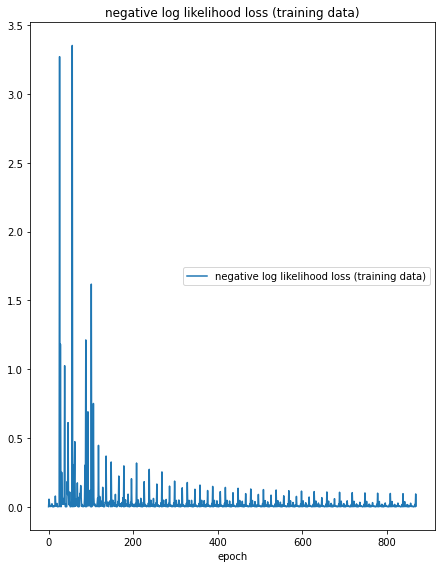

negative log likelihood loss (training data)
	negative log likelihood loss (training data) 	 (min:    0.000, max:    3.353, cur:    0.005)


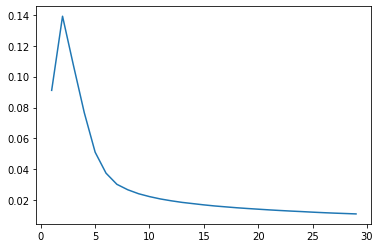

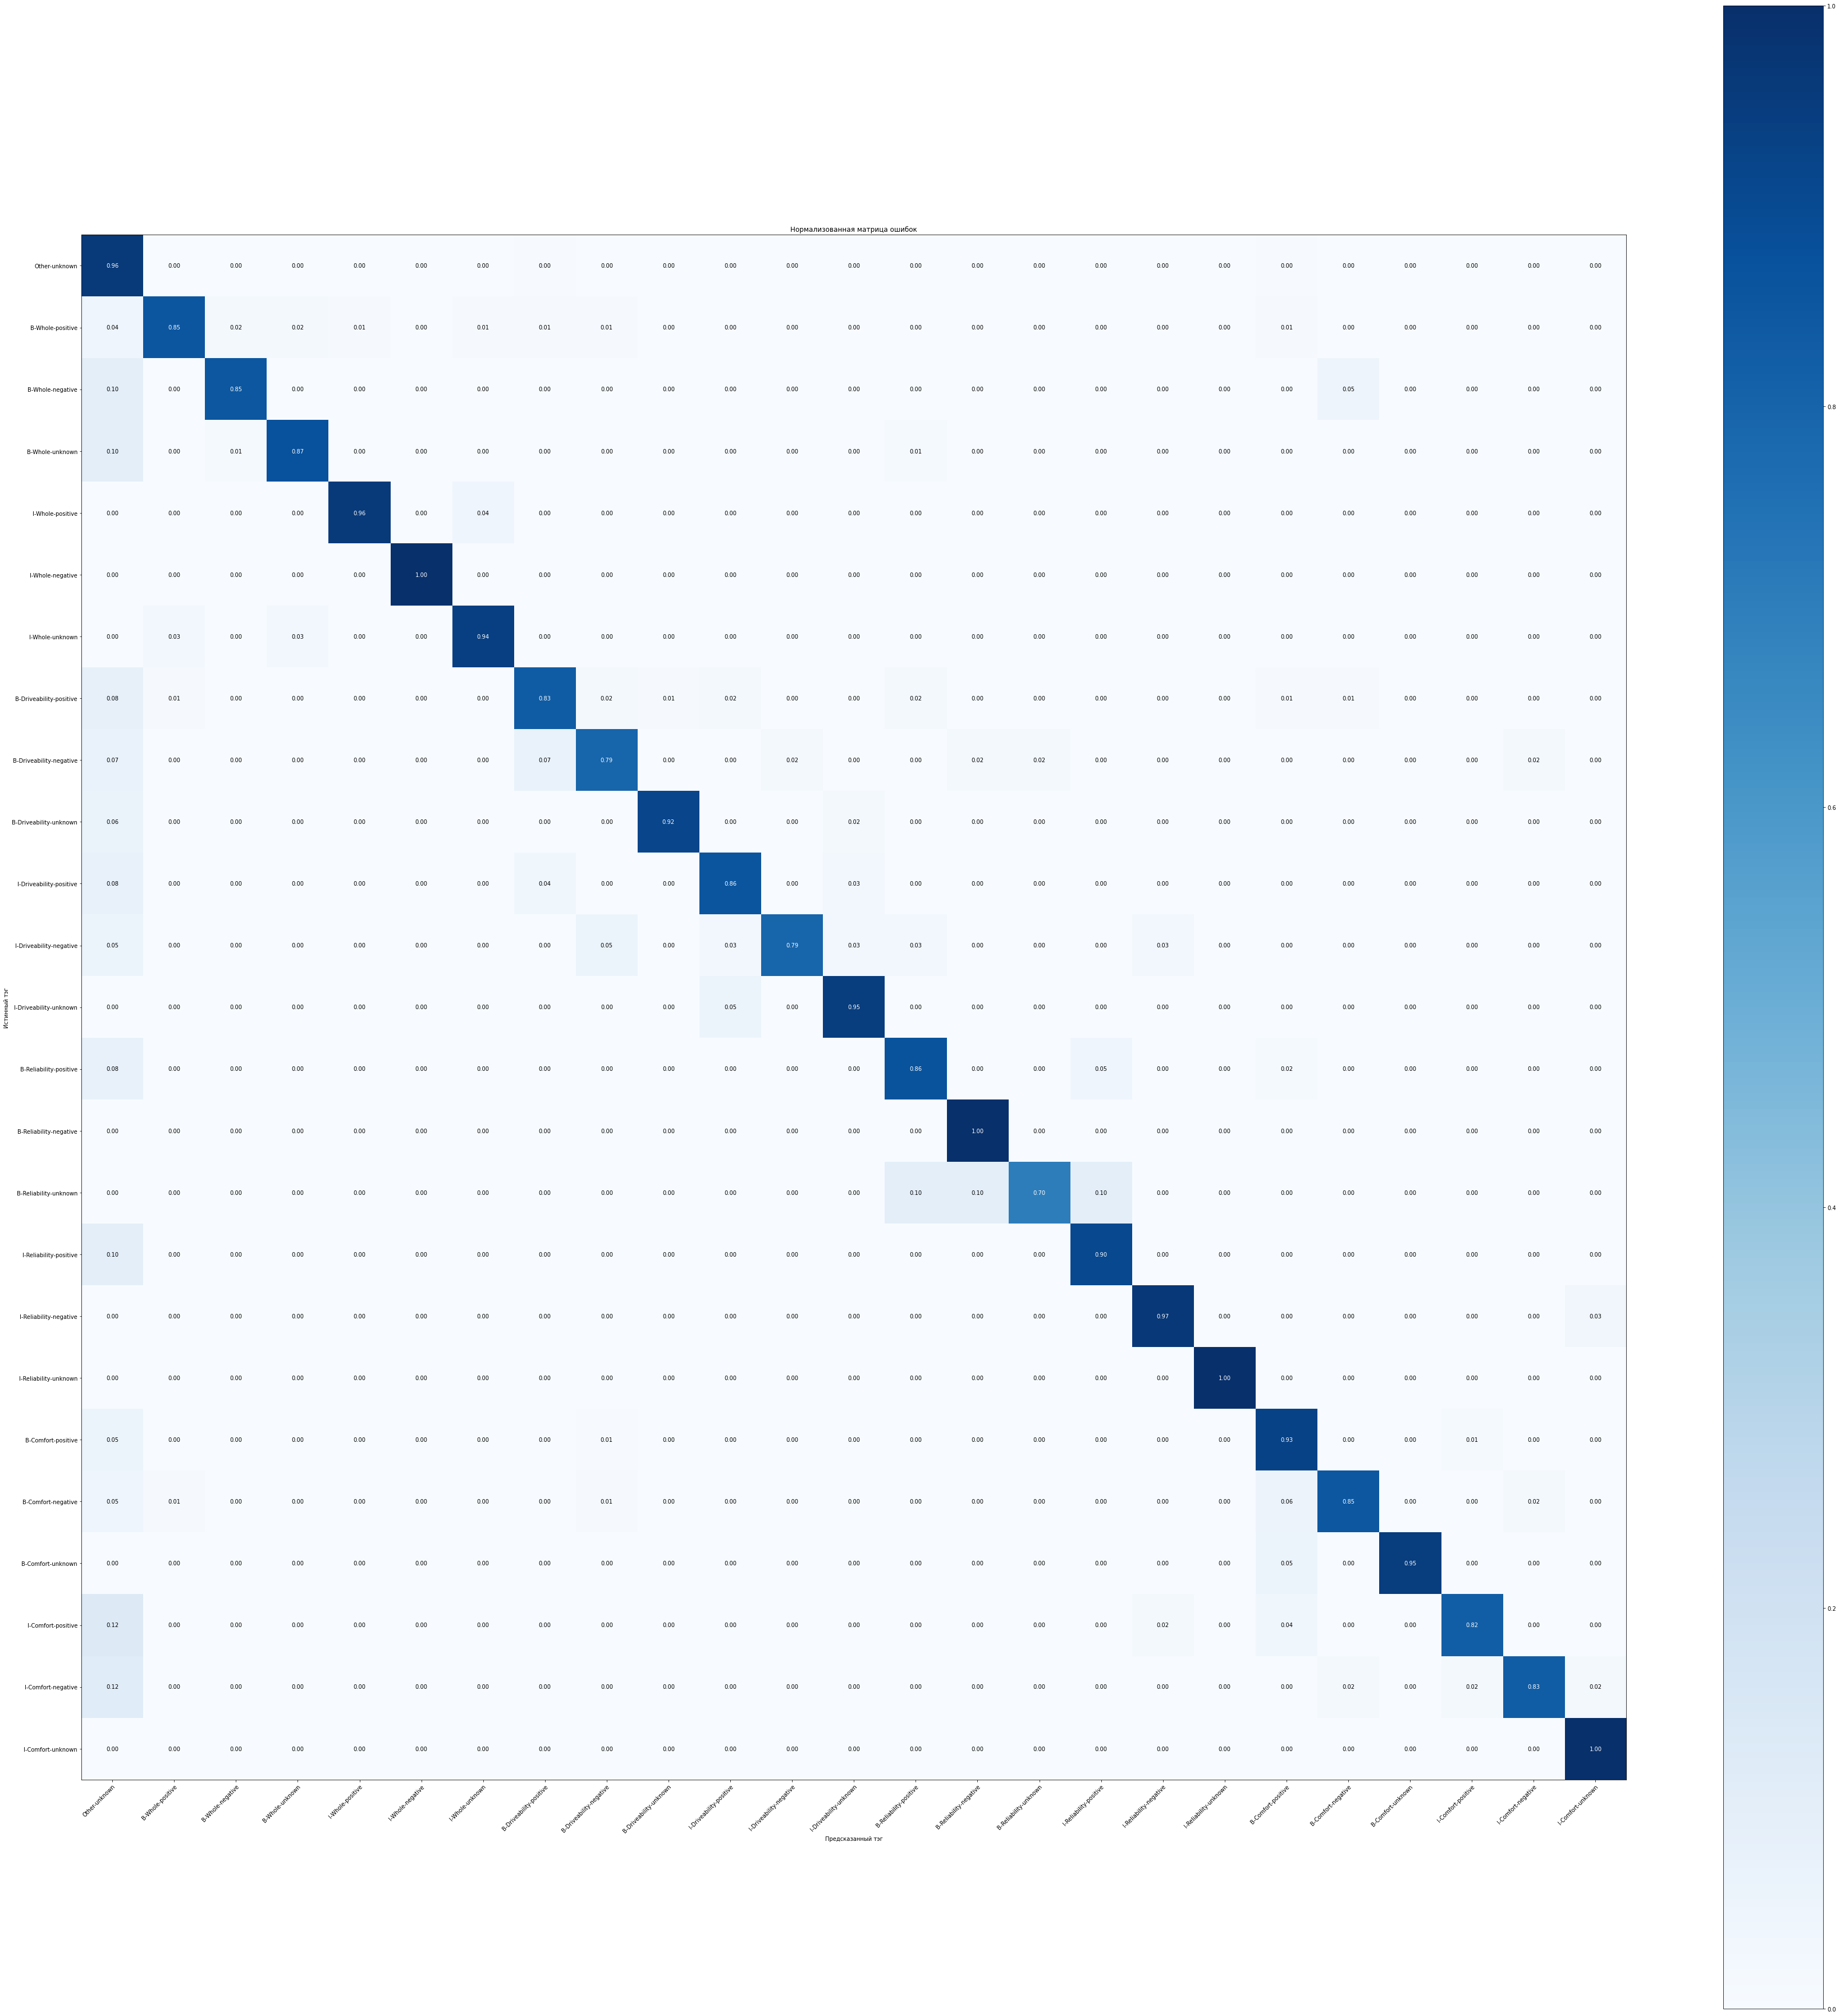

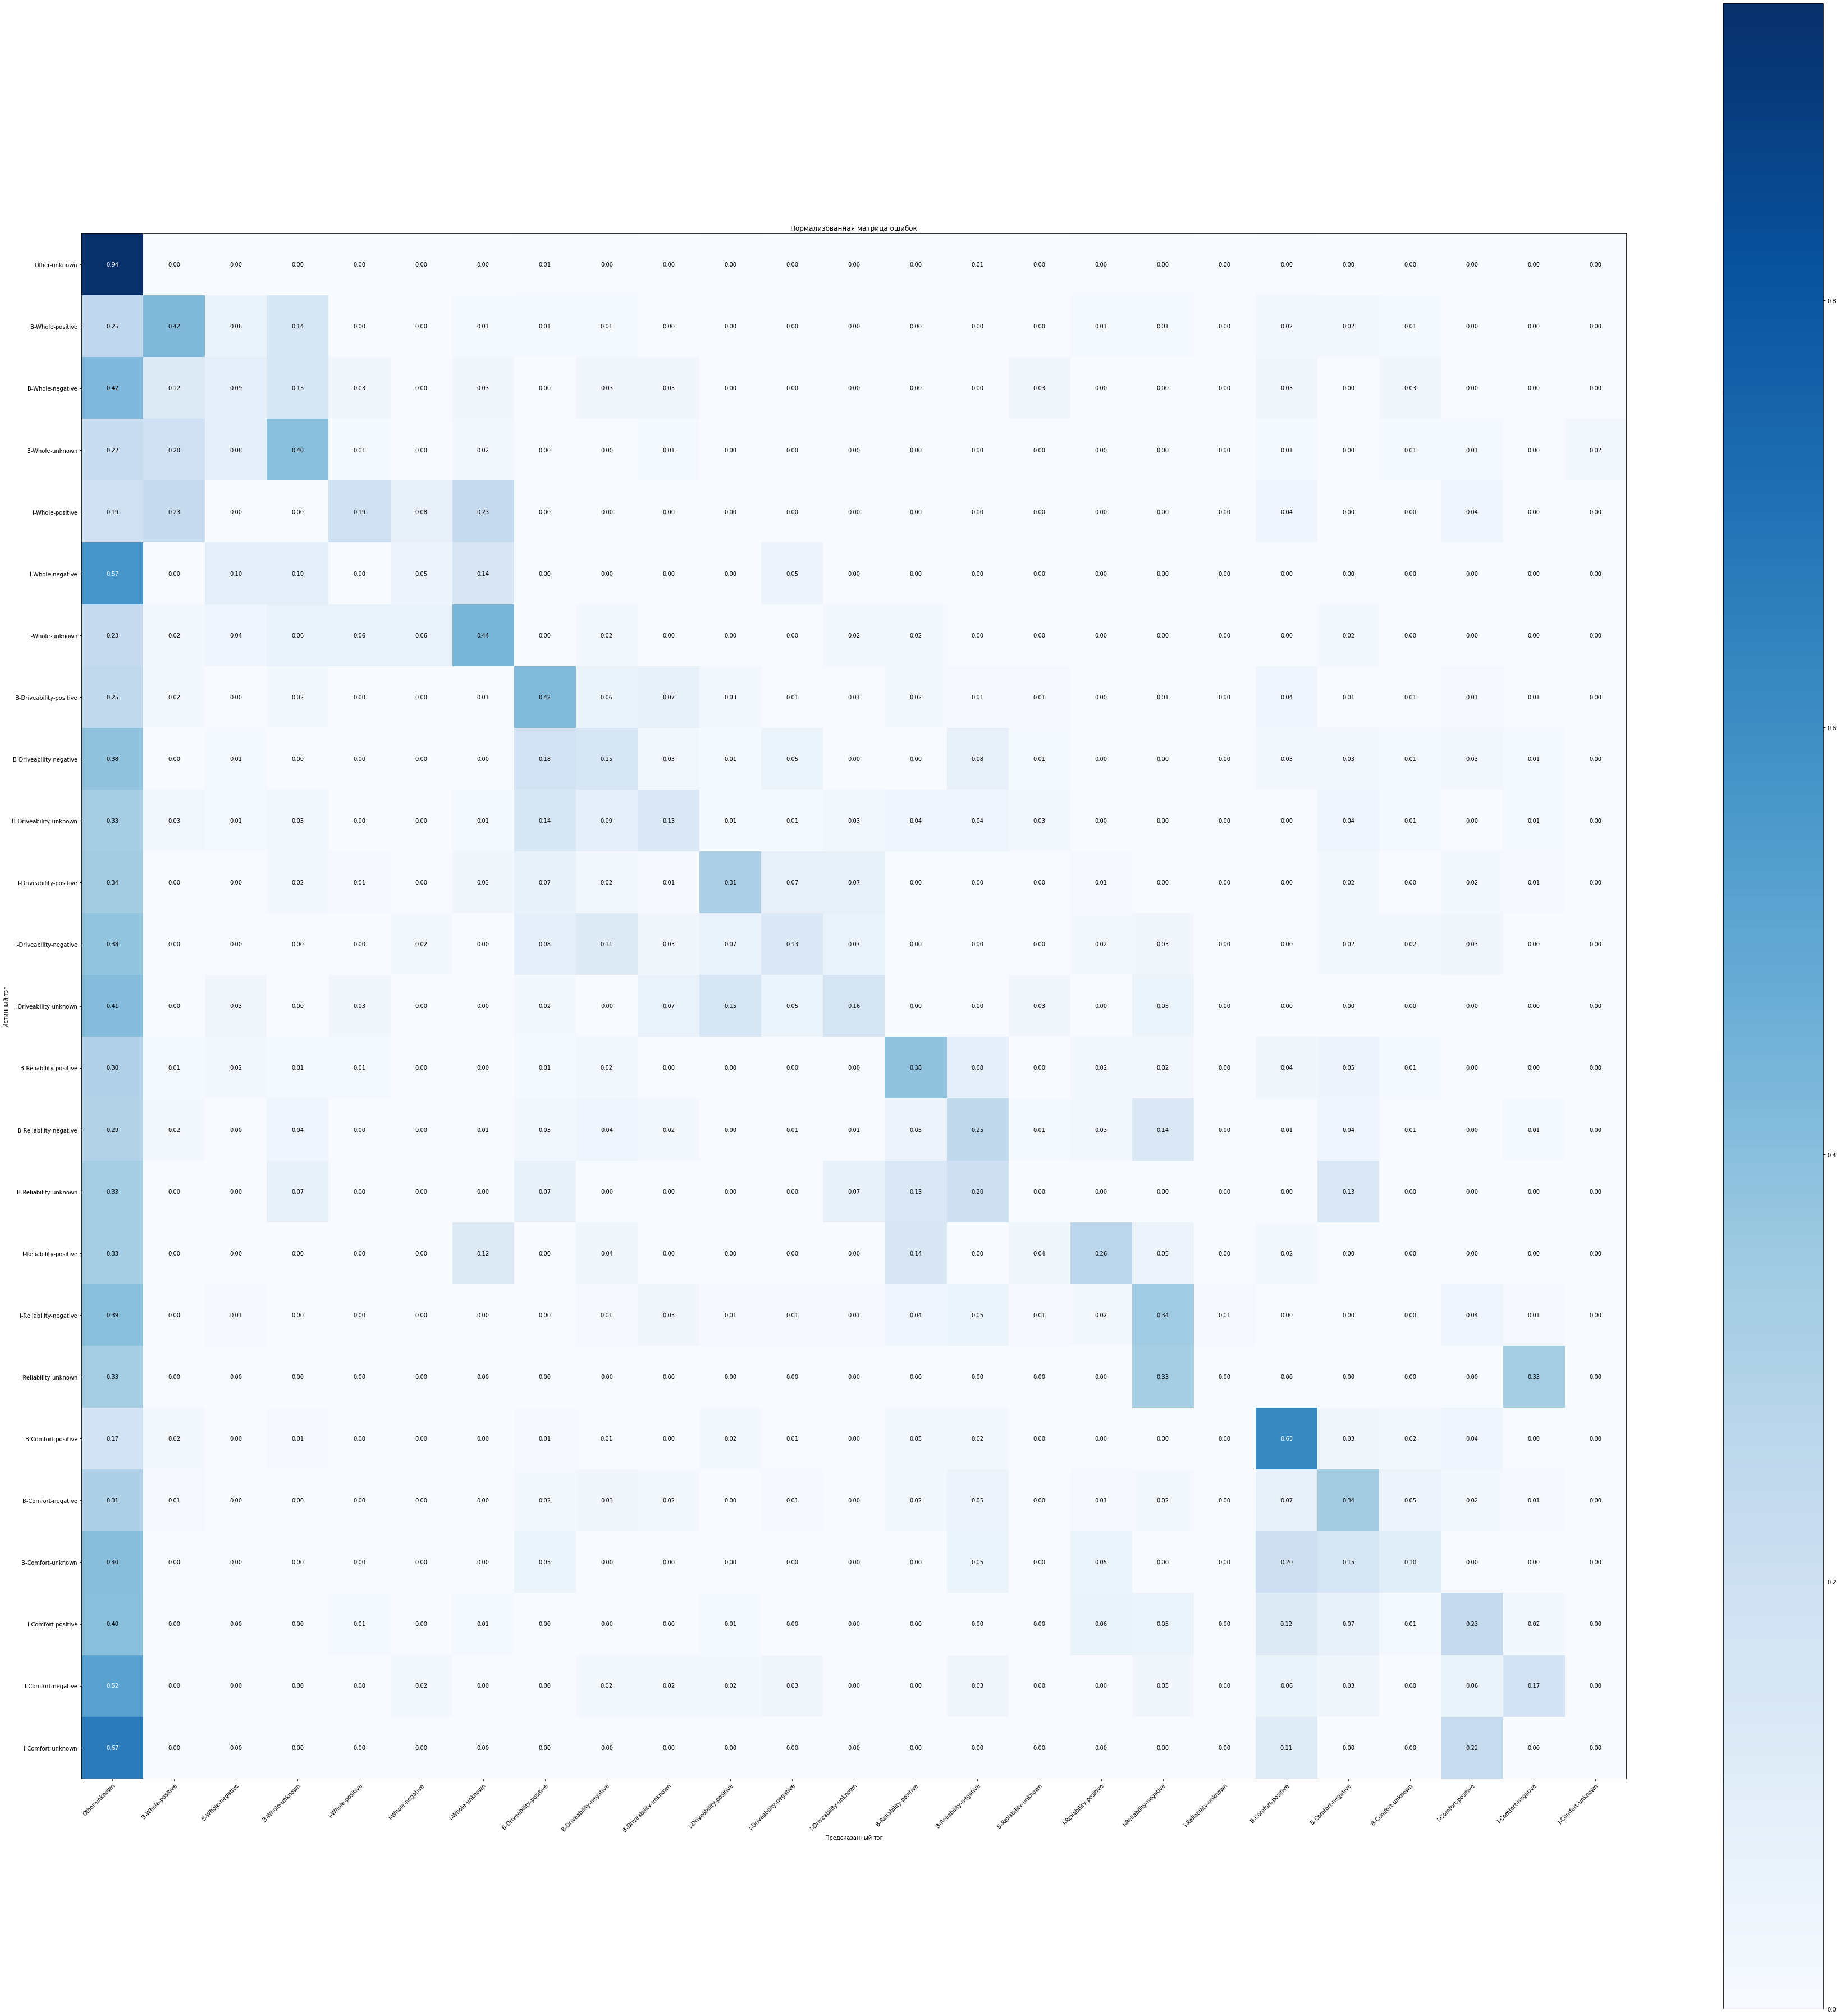

In [ ]:
ordered_classes = [
    'Other-unknown',
    'B-Whole-positive', 'B-Whole-negative', 'B-Whole-unknown',
    'I-Whole-positive', 'I-Whole-negative', 'I-Whole-unknown',
    'B-Driveability-positive', 'B-Driveability-negative', 'B-Driveability-unknown',
    'I-Driveability-positive', 'I-Driveability-negative', 'I-Driveability-unknown',
    'B-Reliability-positive', 'B-Reliability-negative', 'B-Reliability-unknown',
    'I-Reliability-positive', 'I-Reliability-negative', 'I-Reliability-unknown',
    'B-Comfort-positive', 'B-Comfort-negative', 'B-Comfort-unknown',
    'I-Comfort-positive', 'I-Comfort-negative', 'I-Comfort-unknown'
]

def init_models(range_num_epochs):
    models = []

    for num_epochs in range_num_epochs:
        classes_indexer = ClassesIndexer(classes)
        words_indexer   = WordsIndexer()

        EMBEDDING_DIM = 300
        HIDDEN_DIM    = 32
        TAGSET_SIZE   = len(classes_indexer.class_to_index)

        fastText      = word_embedder
        lstm          = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, bidirectional=True)
        loss_function = nn.NLLLoss(class_weights)

        model = AspectBasedClassifier(
            EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE,
            fastText, lstm, num_epochs, loss_function,
            classes_indexer, words_indexer
        )
        models.append(model)

    return models

models = init_models(range(7,30))

f1_micro_metrics_per_model = []
f1_micro_metrics_per_model_test = []
for model in models:
    f1_micro_metrics = []
    for iteration, data in enumerate(KFold(n_splits=7, shuffle=False).split(range(len(dataset)))):
        train_dataset = dataset[data[0]]
        validation_dataset = dataset[data[1]]
        # размер обучающей выборки = 3000 размер валидационной выборки = 500
        model.fit(train_dataset, iteration)
        validation_metrics = model.get_metrics(ordered_classes, validation_dataset, iteration)
        f1_micro_metrics.append(validation_metrics['f1_micro'])
        with open(f'model-num_epochs_{model.num_epochs}-fild_{iteration}.csv', 'w') as metrics_file:
            wr = csv.writer(metrics_file, quoting=csv.QUOTE_ALL)
            wr.writerows(model.metrics_table)
    f1_micro_metrics_per_model.append((np.mean(f1_micro_metrics), model))
    test_metrics = model.get_metrics(ordered_classes, test_hold_dataset)
    f1_micro_metrics_per_model_test.append((test_metrics['f1_micro'], model))

 ## Подбор лучшей модели сравнением метрики F1_micro

Best F1_micro (validation dataset): 0.9026171806806167


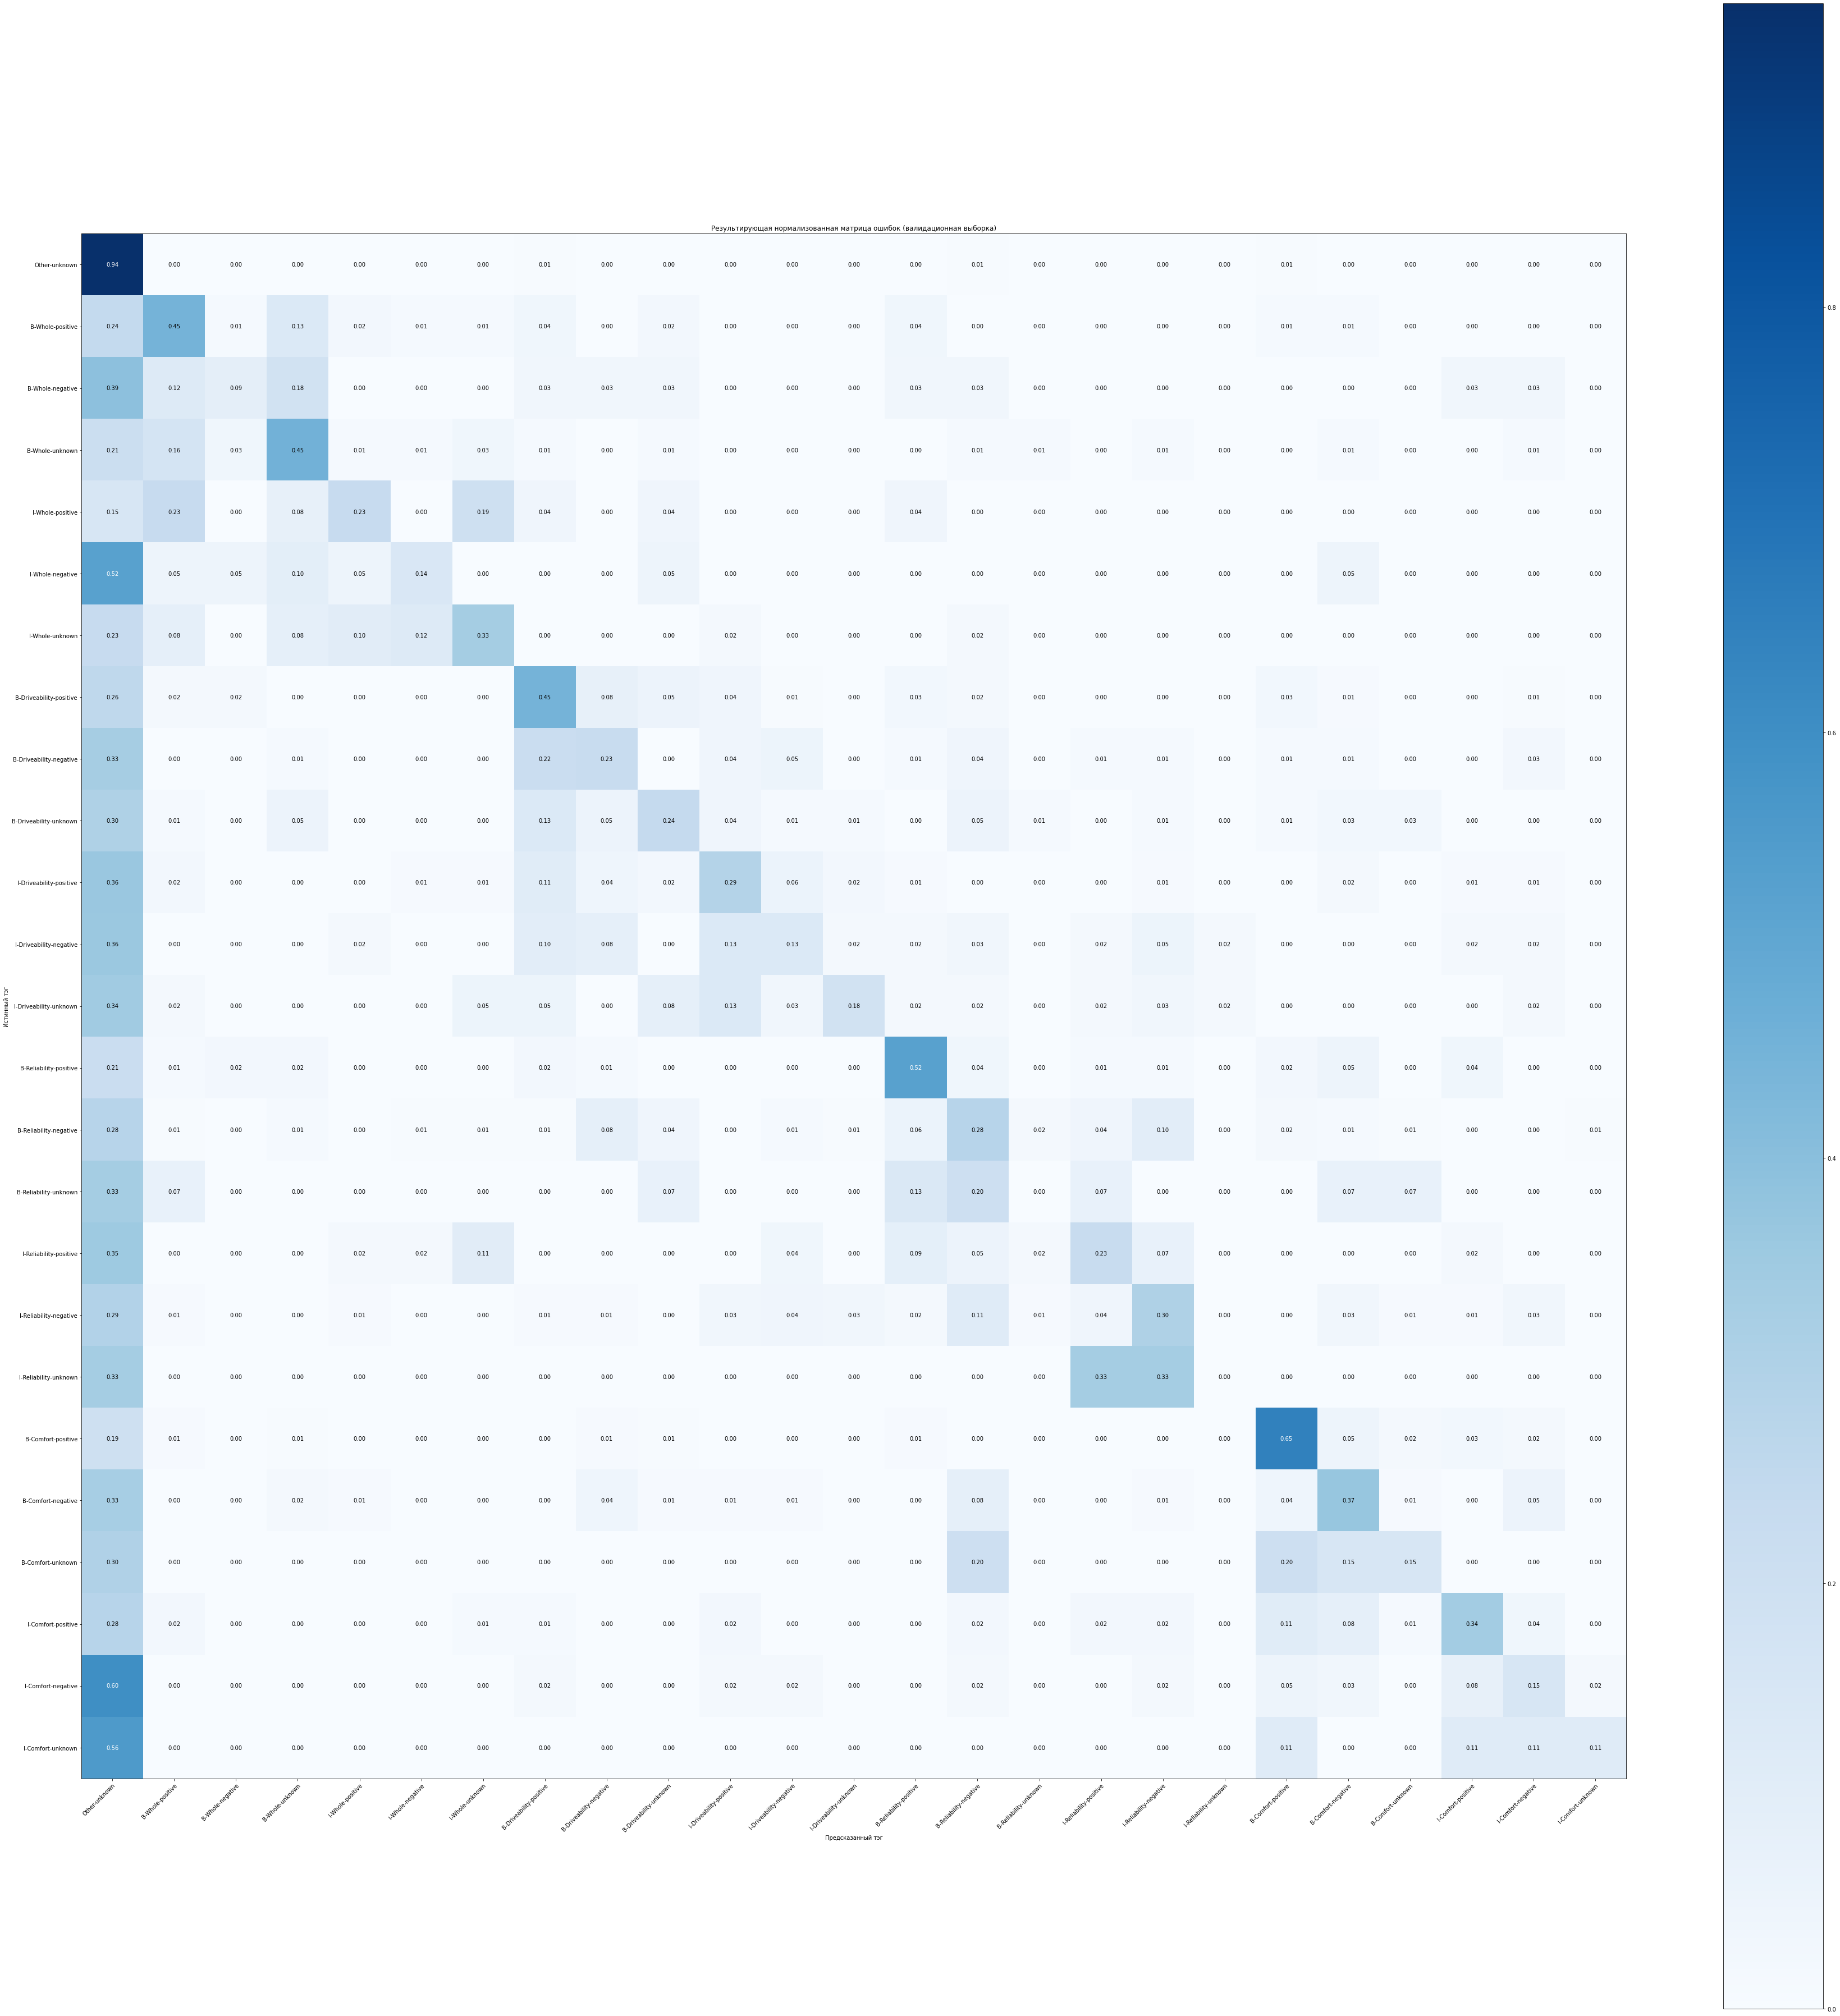

Best F1_micro (validation dataset): 0.9026171806806167



KeyboardInterrupt



In [ ]:
best_f1_micro,best_model = f1_micro_metrics_per_model[0]
for f1_micro,model in f1_micro_metrics_per_model:
    if f1_micro > best_f1_micro:
        best_f1_micro = f1_micro
        best_model = model
print(f'Best F1_micro (validation dataset): {best_f1_micro}')
plot_confusion_matrix(best_model.metrics['confusion_matrix'], classes=ordered_classes, normalize=True, title='Результирующая нормализованная матрица ошибок (валидационная выборка)')
plt.show()

## Тестирование

Best F1_micro (test dataset): 0.8270171844770684
Best num epochs (test dataset): 17


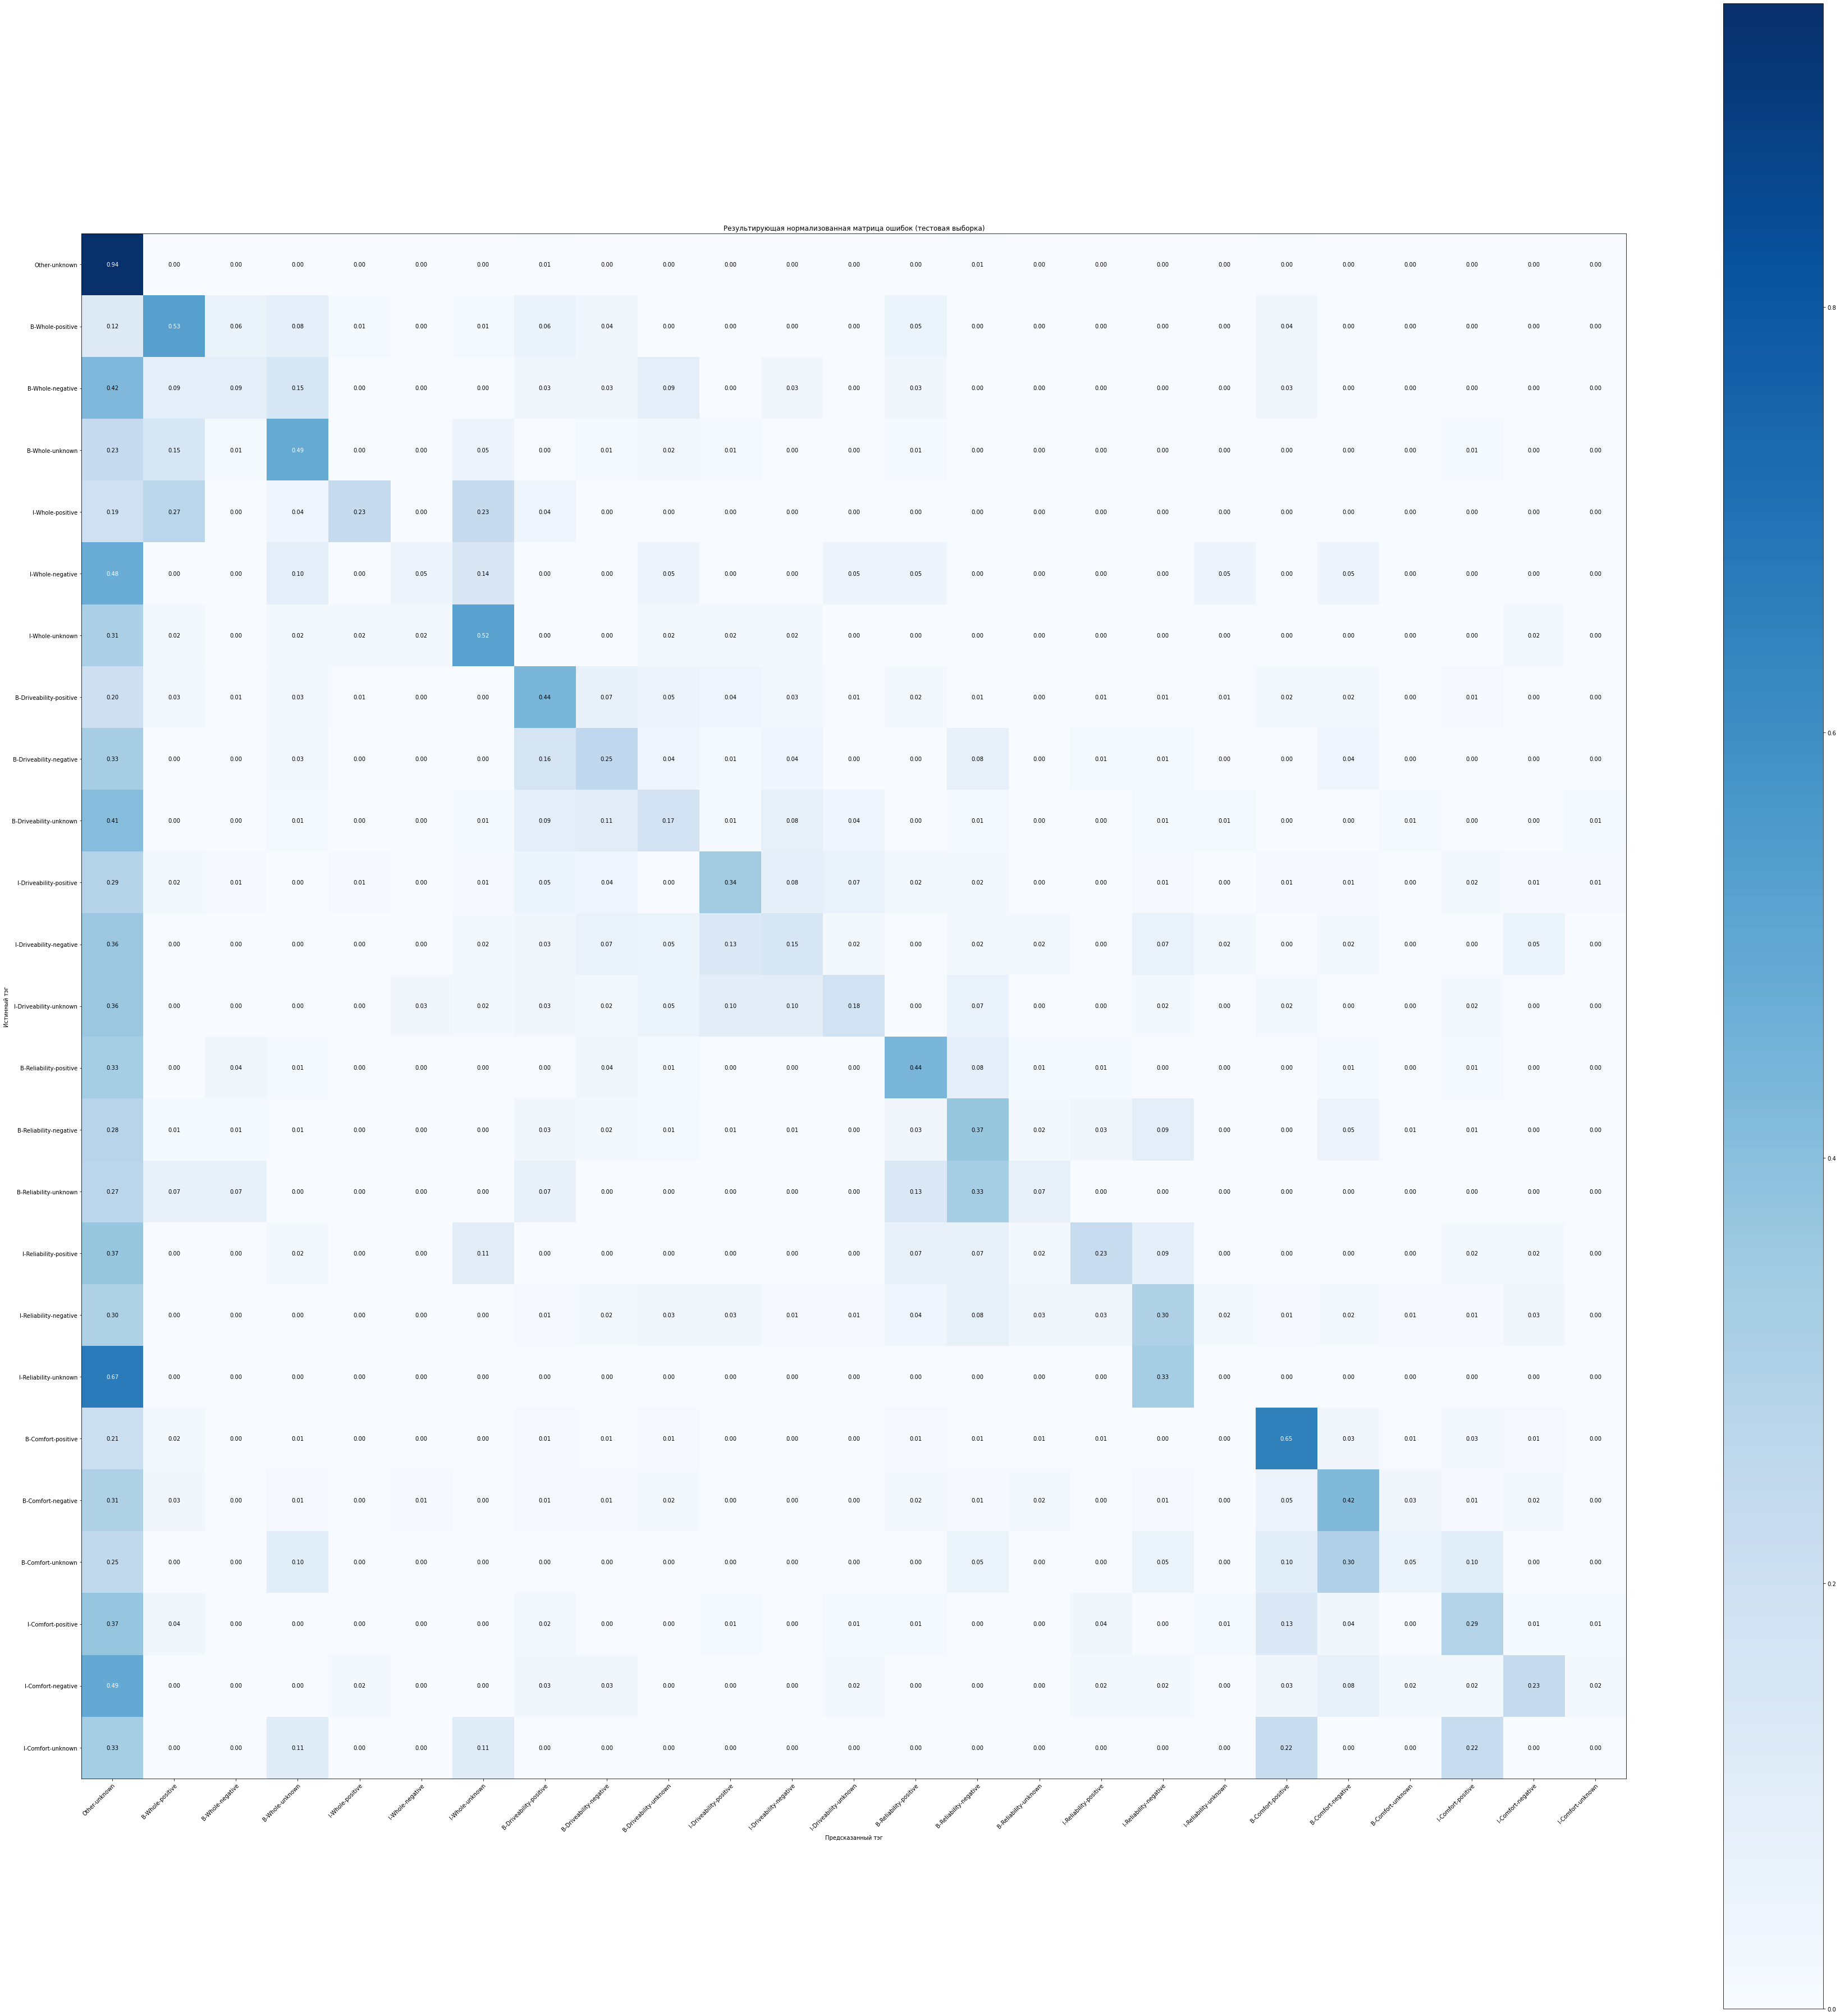

In [ ]:
best_f1_micro_test,best_model_test = f1_micro_metrics_per_model_test[0]
for f1_micro_test,model_test in f1_micro_metrics_per_model_test:
    if f1_micro_test > best_f1_micro_test:
        best_f1_micro_test = f1_micro_test
        best_model_test = model_test
print(f'Best F1_micro (test dataset): {best_f1_micro_test}')
print(f'Best num epochs (test dataset): {best_model_test.num_epochs}')
plot_confusion_matrix(best_model_test.metrics['confusion_matrix'], classes=ordered_classes, normalize=True, title='Результирующая нормализованная матрица ошибок (тестовая выборка)')
plt.show()

# Примеры

In [ ]:
# for i in range(0,10):
#     words, classes    = dataset[np.random.randint(0,3500)]
#     classes_predicted = classes_indexer.indices_to_classes(best_model_test.predict(words))
#
#     print('истинные классы:')
#     text, spans = generate_markup(words, classes)
#     show_markup(text, spans)
#
#     print('предсказанные классы:')
#     text, spans = generate_markup(words, classes_predicted)
#     show_markup(text, spans)
#     print()

In [ ]:
# example_words = ['Крутое', 'авто!']
# class_predicted_init = best_model_test.predict(example_words)
# classes_predicted = classes_indexer.indices_to_classes(class_predicted_init)
# print(f'class_predicted_init: {class_predicted_init}')
# print('предсказанные классы:')
# text, spans = generate_markup(example_words, classes_predicted)
# show_markup(text, spans)
# print()

## Сервер обработки запросов на разметку текста

In [17]:
# total_words = []
# total_classes = []
# for words,classes in dataset:
#     if len(words) == len(classes):
#         total_words += words
#         total_classes += classes
#
# # words,classes = dataset[np.random.randint(0,3500)]
#
# # torch.save(best_model, 'aspect_sentiment.pth.zip')
# # imported_model = torch.load('aspect_sentiment.pth.zip')
# best_model.eval()
# # length = 2048 - len(words)
# # words += [''] * length
# example = words_indexer.words_to_index(total_words)
# print(f'example shape: {example.shape}')
# traced_script_module = torch.jit.trace(best_model, example)
# traced_script_module.save("aspect_sentiment.pt")
# imported_model = torch.load('aspect_sentiment.pt')
# imported_model.eval()
# classes_predicted_indices = np.argmax(np.array(imported_model(words_indexer.words_to_index(total_words))), axis=1)
# print(f'classes_predicted_indices: {classes_predicted_indices}')
# classes_predicted = classes_indexer.indices_to_classes(classes_predicted_indices)
# print('истинные классы:')
# text, spans = generate_markup(total_words, total_classes)
# show_markup(text, spans)
# print('предсказанные классы:')
# text, spans = generate_markup(total_words, classes_predicted)
# show_markup(text, spans)
# print()

In [ ]:
best_model.eval()
torch.save(best_model, 'aspect_sentiment.pth')

In [17]:
aspect_sentiment_model = torch.load('aspect_sentiment.pth')
aspect_sentiment_model.eval()

AspectBasedClassifier(
  (hidden_layer): LSTM(300, 32, bidirectional=True)
  (linear_layer): Linear(in_features=64, out_features=25, bias=True)
  (loss_function): NLLLoss()
)

In [ ]:
from http.server import BaseHTTPRequestHandler
from http.server import HTTPServer

class HttpGetHandler(BaseHTTPRequestHandler):
    """Обработчик с реализованным методом do_GET."""

    def do_POST(self):
        content_length = int(self.headers['Content-Length'])
        request = self.rfile.read(content_length).decode('utf-8')
        print(f'recived post request: {request}')

        words = word_tokenizer.tokenize(request)
        aspect_sentiment_model_scores = np.array(aspect_sentiment_model(words_indexer.words_to_index(words)))
        classes_predicted = classes_indexer.indices_to_classes(np.argmax(aspect_sentiment_model_scores, axis=1))
        text, spans = generate_markup(words, classes_predicted)
        response = format_markup(text, spans)

        self.send_response(200)
        self.send_header("Content-type", "text/html")
        self.end_headers()
        self.wfile.write('<html><head><meta charset="utf-8">'.encode())
        self.wfile.write(response.encode('utf-8'))

def run(server_class=HTTPServer, handler_class=BaseHTTPRequestHandler):
    server_address = ('', 8000)
    httpd = server_class(server_address, handler_class)
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        httpd.server_close()

run(handler_class=HttpGetHandler)